<a href="https://colab.research.google.com/github/sharlynmuturi/Pytorch-Tutorial/blob/main/credit_card_fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    classification_report, roc_auc_score, precision_recall_curve,
    auc, roc_curve, average_precision_score)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Loading the Dataset

In [34]:
from google.colab import files

uploaded = files.upload()

Saving creditcard.csv to creditcard (1).csv


In [35]:
credit_card_data = pd.read_csv('creditcard.csv')

# Data Exploration

## Checking for missing values

In [36]:
credit_card_data.isnull().values.any()

np.False_

## Correlation Analysis

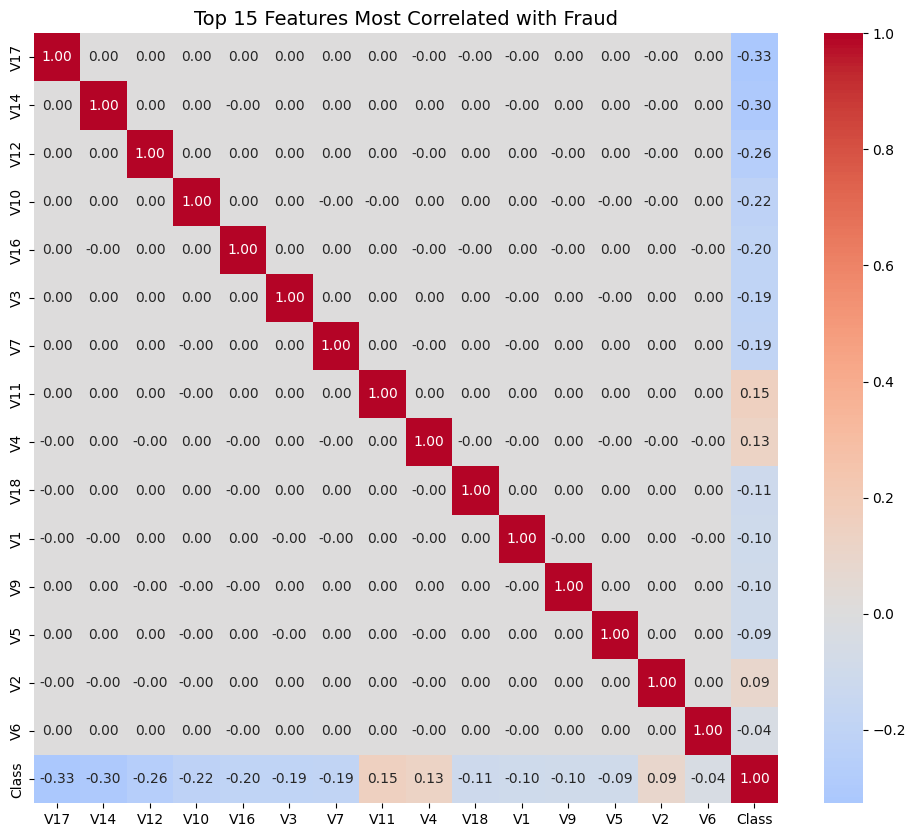

In [37]:
corr_with_class = credit_card_data.corr()['Class']

top_features = corr_with_class.abs().sort_values(ascending=False).iloc[1:16].index.tolist()
top_features.append('Class')

plt.figure(figsize=(12, 10))
sns.heatmap(credit_card_data[top_features].corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Top 15 Features Most Correlated with Fraud", fontsize=14)
plt.show()

## Amount Distribution by Class

*   Keeping all frauds, sample 5000 non-frauds for clarity


/tmp/ipython-input-2601838827.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=credit_card_data_sample, x='Class', y='Amount', palette=['#2ecc71', '#e74c3c'])


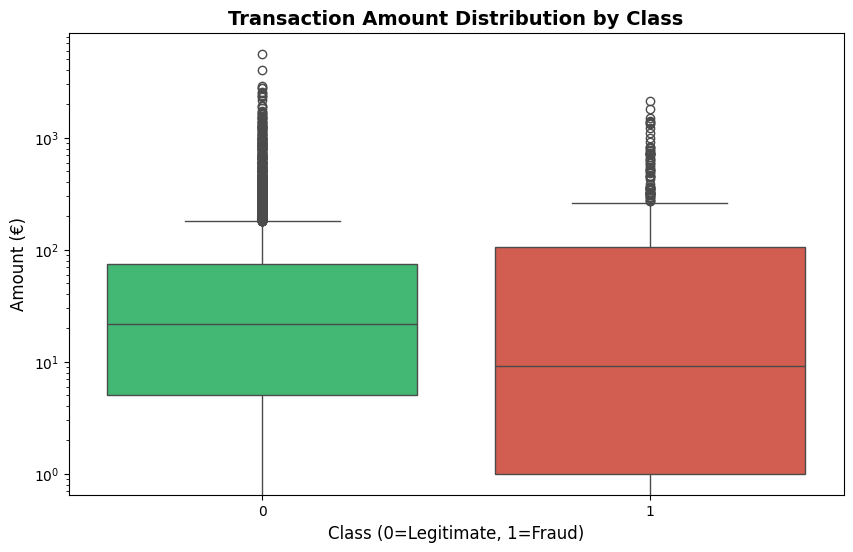

In [38]:
fraud = credit_card_data[credit_card_data['Class'] == 1]
legit_sample = credit_card_data[credit_card_data['Class'] == 0].sample(n=5000, random_state=42)
credit_card_data_sample = pd.concat([fraud, legit_sample])

plt.figure(figsize=(10, 6))
sns.boxplot(data=credit_card_data_sample, x='Class', y='Amount', palette=['#2ecc71', '#e74c3c'])
plt.yscale('log')  # Log scale to handle large differences in amounts
plt.title('Transaction Amount Distribution by Class', fontsize=14, fontweight='bold')
plt.xlabel('Class (0=Legitimate, 1=Fraud)', fontsize=12)
plt.ylabel('Amount (€)', fontsize=12)
plt.show()

## Class Distribution

In [39]:
print('No Frauds', round(credit_card_data['Class'].value_counts()[0]/len(credit_card_data) * 100,2), '% of the dataset')
print('Frauds', round(credit_card_data['Class'].value_counts()[1]/len(credit_card_data) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


/tmp/ipython-input-3778173079.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(credit_card_data['Class'], sort = True)


Text(0, 0.5, 'Frequency')

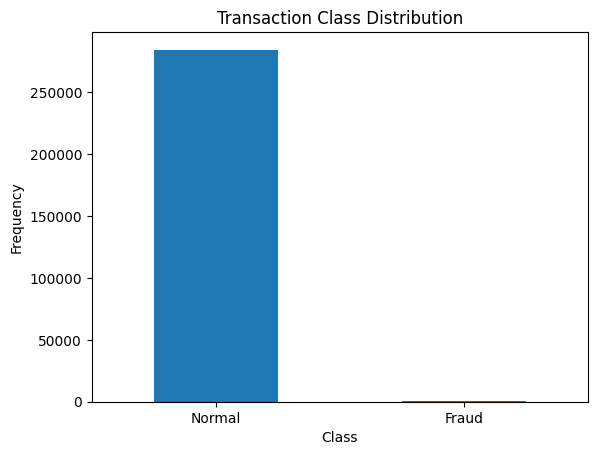

In [40]:
count_classes = pd.value_counts(credit_card_data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), ['Normal', 'Fraud'])
plt.xlabel("Class")
plt.ylabel("Frequency")

# Data Preprocessing

## Train-Test Split

In [41]:
X = credit_card_data.drop(columns='Class', axis=1)
y = credit_card_data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

print(X.shape, X_train.shape, X_test.shape)

(284807, 30) (227845, 30) (56962, 30)


## Feature Scaling

In [42]:
credit_card_data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Features V1-V28 are already standardized due to PCA transformation. We only need to scale Time and Amount which are on different scales.

*   RobustScaler is less sensitive to outliers
*   Fit on training data only
*   Using .loc[] to avoid SettingWithCopyWarning


In [43]:
scaler = RobustScaler()

X_train.loc[:, ['Time', 'Amount']] = scaler.fit_transform(X_train[['Time', 'Amount']])
X_test.loc[:, ['Time', 'Amount']] = scaler.transform(X_test[['Time', 'Amount']])

print(X_train[['Time', 'Amount']].describe())

                Time         Amount
count  227845.000000  227845.000000
mean        0.118594       0.923070
std         0.558106       3.510877
min        -0.996179      -0.306535
25%        -0.358376      -0.229204
50%         0.000000       0.000000
75%         0.641624       0.770796
max         1.035330     357.658632


## Handling Class Imbalance with SMOTE and Random Undersampling

In [44]:
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)


comparison_data = {
    'Technique': ['Original', 'SMOTE', 'Undersampling', 'Class Weights'],
    'Fraud Count': [
        (y_train == 1).sum(),
        (y_train_smote == 1).sum(),
        (y_train_rus == 1).sum(),
        (y_train == 1).sum()
    ],
    'Non-Fraud Count': [
        (y_train == 0).sum(),
        (y_train_smote == 0).sum(),
        (y_train_rus == 0).sum(),
        (y_train == 0).sum()
    ],
    'Total Size': [
        len(y_train),
        len(y_train_smote),
        len(y_train_rus),
        len(y_train)
    ],
    'Notes': [
        'Extremely imbalanced',
        'Balanced with synthetic data',
        'Balanced but small',
        'Original size, weighted loss'
    ]
}

comparison = pd.DataFrame(comparison_data)

print(comparison.to_string(index=False))

    Technique  Fraud Count  Non-Fraud Count  Total Size                        Notes
     Original          394           227451      227845         Extremely imbalanced
        SMOTE       227451           227451      454902 Balanced with synthetic data
Undersampling          394              394         788           Balanced but small
Class Weights          394           227451      227845 Original size, weighted loss


## Model Training & Evaluation

*   Logistic Regression with balanced class weights
*   Random Forest with SMOTE
*   XGBoost with SMOTE
*   LightGBM with SMOTE



In [45]:
from lightgbm import LGBMClassifier

In [46]:
results = {
    'Model': [],
    'Technique': [],
    'PR-AUC': [],
    'ROC-AUC': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

def evaluate_model(model, X_train_data, y_train_data, X_test_data, y_test_data, model_name, technique):

    # Train
    model.fit(X_train_data, y_train_data)

    # Predict
    y_pred = model.predict(X_test_data)
    y_pred_proba = model.predict_proba(X_test_data)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test_data)

    # Calculate metrics
    pr_auc = average_precision_score(y_test_data, y_pred_proba)
    roc_auc = roc_auc_score(y_test_data, y_pred_proba)

    precision = precision_score(y_test_data, y_pred)
    recall = recall_score(y_test_data, y_pred)
    f1 = f1_score(y_test_data, y_pred)

    # Store results
    results['Model'].append(model_name)
    results['Technique'].append(technique)
    results['PR-AUC'].append(pr_auc)
    results['ROC-AUC'].append(roc_auc)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1-Score'].append(f1)

    print(f"\n{'='*60}")
    print(f"{model_name} - {technique}")
    print(f"{'='*60}")
    print(f"PR-AUC: {pr_auc:.4f} | ROC-AUC: {roc_auc:.4f}")
    print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
    print(f"\nConfusion Matrix:")
    print(confusion_matrix(y_test_data, y_pred))

    return model, y_pred_proba

In [47]:
lr_model, lr_proba = evaluate_model(
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    X_train, y_train, X_test, y_test,
    'Logistic Regression', 'Class Weights'
)

rf_model, rf_proba = evaluate_model(
    RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    X_train_smote, y_train_smote, X_test, y_test,
    'Random Forest', 'SMOTE'
)

xgb_model, xgb_proba = evaluate_model(
    XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, eval_metric='logloss'),
    X_train_smote, y_train_smote, X_test, y_test,
    'XGBoost', 'SMOTE'
)

lgbm_model, lgbm_proba = evaluate_model(
    LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, verbosity=-1),
    X_train_smote, y_train_smote, X_test, y_test,
    'LightGBM', 'SMOTE'
)


Logistic Regression - Class Weights
PR-AUC: 0.7577 | ROC-AUC: 0.9917
Precision: 0.0648 | Recall: 0.9490 | F1: 0.1213

Confusion Matrix:
[[55522  1342]
 [    5    93]]

Random Forest - SMOTE
PR-AUC: 0.8347 | ROC-AUC: 0.9876
Precision: 0.5346 | Recall: 0.8673 | F1: 0.6615

Confusion Matrix:
[[56790    74]
 [   13    85]]

XGBoost - SMOTE
PR-AUC: 0.8694 | ROC-AUC: 0.9830
Precision: 0.3850 | Recall: 0.8878 | F1: 0.5370

Confusion Matrix:
[[56725   139]
 [   11    87]]

LightGBM - SMOTE
PR-AUC: 0.8401 | ROC-AUC: 0.9619
Precision: 0.3529 | Recall: 0.8571 | F1: 0.5000

Confusion Matrix:
[[56710   154]
 [   14    84]]
